### Set up

In [25]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import pickle
import time
import sys
from collections import Counter


In [29]:
# ==================== Define functions ====================

def MyRsq(predict, actual): # Function to calculate R-squared
    dif = predict - actual
    dif = dif ** 2
    mse = np.mean(dif)
    rsq = 1 - mse / np.var(actual)
    return rsq

def Extract_Features(PD, Type = 'Full_Cov'): # Functions that only extract interesting features, remove unrelated columns in the pandas dataframe
    # Input PD is the entire pandas dataframe read from csv (result from Rds files of R)
    # Type is an approach that you want to run
    #   - Full_Cov: Keep all features --> remove x-y coordinates and FOI column
    #   - Only_Bio: Only keep Bioclimatic Features --> remove x-y coordinates, FOI column, and other not-bioclimatic columns
    # Output is an pandas dataframe containing only interesting features columns
    # Note: You need to check the names of columns that you want to remove
    
    if (Type == 'Full_Cov'):
        # Full Covariates --> Using all covariates --> remove x-y coordinates and FOI values columns (keep all features)
        if ('FOI' in PD.columns): # This check is for Endemic dataframe since it does not have FOI column    
            Interest_Features = PD.drop(['x', 'y', 'FOI'], axis = 1)
        else:
            Interest_Features = PD.drop(['x', 'y'], axis = 1)
    else:
        # Only Bio Covariates --> Only using bioclimatic --> remove x-y coordinates, FOI columns, and other columns that are not bioclimatic
        if ('FOI' in PD.columns): 
            Interest_Features = PD.drop(['x', 'y', 'DG_000_014bt_dens', 'Elv', 'Pigs', 'Pop_Count_WP_SEDAC_2015', 'Rice', 'UR', 'VD', 'FOI'], axis = 1)
        else:
            Interest_Features = PD.drop(['x', 'y', 'DG_000_014bt_dens', 'Elv', 'Pigs', 'Pop_Count_WP_SEDAC_2015', 'Rice', 'UR', 'VD'], axis = 1)
    return Interest_Features

np.random.seed(5) # set seed to regenerate the same random result





In [3]:
# ==================== Set up parameters and Read data ====================

Typemodel = 'Full_Cov' # if Full Cov model --> More detail in above Extract_Features functions
#Typemodel = 'Only_Bio' # if only bio model 

Train_Portion = 0.7 # Portion of Train - Validate - Test
Validate_Portion = (1 - Train_Portion) / 2

resolution_grid = 400
Name_Grid_File = 'Grid_' + str(resolution_grid) + '_' + str(resolution_grid) + '.csv'

print('[Type Model] You have chosen ' + Typemodel)

CurDir = os.getcwd() + '/'
Data_All = CurDir + 'Generate/Python_CSV/EM_Imputed_Features_Study.csv' # 'Directory/to/your/EM_Imputed_Features_Study.csv'
Grid = CurDir + 'Generate/Grids_CSV/' + Name_Grid_File # 'Directory/to/your/Grid/' + Name_Grid_File
Data_EndemicDF = CurDir + 'Generate/Python_CSV/Imputed_Features_Endemic.csv' # 'Directory/to/your/Imputed_Features_Endemic.csv'

# Directory to the folder that you want this script exports files to (remember to have slash '/' at the end)
# Default is to create a subfolder named Python_Export and save result to that subfolder   
Savepath = CurDir + 'Generate/Python_Export/' 
if not os.path.exists(Savepath):
    os.makedirs(Savepath)

# Read csv and store in dataframe in pandas
AllData = pd.read_csv(Data_All)
Grid = pd.read_csv(Grid)  
EndemicDF = pd.read_csv(Data_EndemicDF)
EndemicDF = EndemicDF.drop(['FOI'], axis = 1) # remove FOI column (if it has)

# Remove Pop_2015 density (if wanted, since already have Pop_Count people) --> Check feature name again
# AllData = AllData.drop(['Pop_2015'], axis = 1)
# EndemicDF = EndemicDF.drop(['Pop_2015'], axis = 1)

# Check if matching coordinator
if (len(AllData.iloc[:, :2].merge(Grid.iloc[:, :2])) == len(AllData.iloc[:, :2])):
    print('[Checking Calibration] Matched Coordinators')
    # Recreate grid to match with AllData in case of nrow of 2 dataframe is different
    t = pd.merge(AllData.iloc[:, : 2].reset_index(), Grid.iloc[:, : 2].reset_index(), on=['x','y'], suffixes=['_1','_2'])
    Grid = Grid.iloc[t['index_2'], :]
    del t
else:
    sys.exit('[Stop Program] Grid and Data File do not match coordinators --> Check again')





[Type Model] You have chosen Full_Cov
[Checking Calibration] Matched Coordinators


In [4]:
AllData.head()

,x,y,Bio_01,Bio_02,Bio_03,Bio_04,Bio_05,Bio_06,Bio_07,Bio_08,...,Bio_18,Bio_19,DG_000_014bt_dens,Elv,Pigs,Rice,UR,VD,Adjusted_Pop_Count_2015,FOI
0,13717.407892,5959.817018,-3.533434,14.667511,24.080265,1743.920532,25.633081,-35.277302,60.910385,16.902985,...,280.531250,15.885687,0.096940,324.425049,0.086128,8.804602,1,0.285594,27.158179,0.163308
1,13722.407892,5959.817018,-3.515078,14.740572,24.211077,1737.165649,25.591284,-35.291855,60.883141,16.848240,...,281.375214,16.805054,0.106271,339.754822,0.088851,0.000000,1,0.282270,46.891705,0.164386
2,13727.407892,5959.817018,-3.505363,14.655778,24.143412,1735.075928,25.490971,-35.211075,60.702045,16.827511,...,281.311707,16.730371,0.110514,328.791656,0.055739,0.000000,1,0.296362,29.772409,0.165014
3,13747.407892,5959.817018,-3.203640,14.476027,23.880190,1734.776611,25.709829,-34.909279,60.619106,17.131897,...,281.548340,16.541552,2.518467,281.210266,0.125748,5.982415,1,0.187785,10.536764,0.163172
4,13757.407892,5959.817018,-3.142176,15.133987,24.704348,1729.607788,26.100000,-35.160149,61.260151,17.148170,...,282.543854,16.618938,2.763509,273.763184,0.072534,0.000000,1,0.313313,13.470044,0.163207


In [9]:
# ==================== Sampling Grids to define which Grids will be for Train-Validate-Test ====================

# Count freq of pix in each grid
Grid_column = Grid.iloc[:, 2]
Grid_column = np.array(Grid_column)
d = Counter(Grid_column)
grid_freq = np.array(list(d.values())) # number of pix in each grid_numb (belowed)
grid_numb = np.array(list(d.keys()))
del d

# ----- Preprocessing for Sampling train and validate -----
idx_grid_numb_less = np.where(grid_freq < 100)[0] # find idx of grid containing less than 100 pix --> these grids will be automaticly in training set
idx_grid_numb_high = np.where(grid_freq >= 100)[0] # find idx of grid containing more than 100 pix --> these grids will be randomly chosen for training

grid_numb_train_1 = grid_numb[idx_grid_numb_less]
grid_numb_sample = grid_numb[idx_grid_numb_high]

ngrid_train_2 = round(len(grid_numb_sample)*0.7) # 70% train --- 30% test (validate)
ngrid_validate = round(len(grid_numb_sample)*0.15)
ngrid_test = len(grid_numb_sample) - ngrid_train_2 - ngrid_validate
ngrid_train = len(grid_numb_train_1) + ngrid_train_2

print('[Sampling Grid] Training Grids: ' + str(ngrid_train) + ' ----- Validating Grids: ' + str(ngrid_validate) + ' ----- Testing Grids: ' + str(ngrid_test))

print('===== Sampling Model =====')    
grid_numb_sample_shuffle = np.copy(grid_numb_sample)
np.random.shuffle(grid_numb_sample_shuffle)
grid_numb_train_2 = grid_numb_sample_shuffle[:ngrid_train_2]
grid_numb_validate = grid_numb_sample_shuffle[ngrid_train_2:(ngrid_train_2 + ngrid_validate)]
grid_numb_test = grid_numb_sample_shuffle[(ngrid_train_2 + ngrid_validate):]
grid_numb_train = np.append(grid_numb_train_1, grid_numb_train_2)
del grid_numb_sample_shuffle, grid_numb_train_2

# ----- Take index of pixel for each sub-dataset
idx_train = np.where(np.in1d(Grid_column, grid_numb_train))[0]
idx_validate = np.where(np.in1d(Grid_column, grid_numb_validate))[0]
idx_test = np.where(np.in1d(Grid_column, grid_numb_test))[0]

Type = np.zeros(AllData.shape[0])
Type[idx_train] = 1 # index 1 for train
Type[idx_validate] = 2 # index 2 for validate
Type[idx_test] = 3 # index 3 for validate

# Saving Sampling Grid index having 3 columns: x-y coordinates, and Grid index
Coor_Grid_Index = AllData.iloc[:, 0:2]
Coor_Grid_Index = Coor_Grid_Index.assign(Type = pd.Series(Type).values)
filename_grid = 'Grid_Index_' + str(resolution_grid) + '.csv'
print('[Saving] Save Grid Index')
Coor_Grid_Index.to_csv(Savepath + filename_grid, sep='\t', encoding='utf-8')
print('[Saving] Done Saving Grid Index')





[Sampling Grid] Training Grids: 166 ----- Validating Grids: 30 ----- Testing Grids: 30
===== Sampling Model =====
[Saving] Save Grid Index
[Saving] Done Saving Grid Index


In [10]:
# ==================== Create Train-Validate-Test dataset ====================
# ==================== SJ: Thinning the dataset ====================

# ===== Prepare Train =====
Train = AllData.iloc[idx_train, :]
row_na = Train.isnull().any(1) # check whether a row contains NA or not
#idx_row_na = row_na.nonzero()[0] # find index of row containing NA
#SJ: AttributeError: 'Series' object has no attribute 'nonzero'. This method is deprecated. See below
idx_row_na = row_na.to_numpy().nonzero()[0] # find index of row containing NA

print('[Preprocessing] Total Training containing NA: ' + str(len(idx_row_na)) + ' / ' + str(len(Train)) + ' ----- ' + 
      str(round(len(idx_row_na) / len(Train) * 100, 2)) + '%')
Train_Non_NA = Train.drop(Train.index[idx_row_na]) # remove row containing NA

# SJ: Thinning: take 10%
Train_Non_NA = Train_Non_NA.sample(frac = 0.1, replace = False, random_state = 1)

# ----- Extract Features for model -----
X_train = Extract_Features(Train_Non_NA, Typemodel)
Y_train = Train_Non_NA.FOI
Y_train = np.array(Y_train)

# ===== Prepare Validate =====
Validate = AllData.iloc[idx_validate, :]
row_na = Validate.isnull().any(1) # check whether a row contains NA or not
#idx_row_na = row_na.nonzero()[0] # find index of row containing NA
#SJ: AttributeError: 'Series' object has no attribute 'nonzero'. This method is deprecated. See below
idx_row_na = row_na.to_numpy().nonzero()[0] # find index of row containing NA

print('[Preprocessing] Total Validating containing NA: ' + str(len(idx_row_na)) + ' / ' + str(len(Validate)) + ' ----- ' + 
      str(round(len(idx_row_na) / len(Validate) * 100, 2)) + '%')
Validate_Non_NA = Validate.drop(Validate.index[idx_row_na]) # remove row containing NA

# SJ: Thinning: take 10%
Validate_Non_NA = Validate_Non_NA.sample(frac = 0.1, replace = False, random_state = 1)

# ----- Extract Features for model -----
X_validate = Extract_Features(Validate_Non_NA, Typemodel)
Y_validate = Validate_Non_NA.FOI
Y_validate = np.array(Y_validate)

# ===== Prepare Test =====
Test = AllData.iloc[idx_test, :]
row_na = Test.isnull().any(1) # check whether a row contains NA or not
#idx_row_na = row_na.nonzero()[0] # find index of row containing NA
#SJ: AttributeError: 'Series' object has no attribute 'nonzero'. This method is deprecated. See below
idx_row_na = row_na.to_numpy().nonzero()[0] # find index of row containing NA

print('[Preprocessing] Total Testing containing NA: ' + str(len(idx_row_na)) + ' / ' + str(len(Test)) + ' ----- ' + 
      str(round(len(idx_row_na) / len(Test) * 100, 2)) + '%')
Test_Non_NA = Validate.drop(Test.index[idx_row_na]) # remove row containing NA

# SJ: Thinning: take 10%
Test_Non_NA = Test_Non_NA.sample(frac = 0.1, replace = False, random_state = 1)

# ----- Extract Features for model -----
X_test = Extract_Features(Test_Non_NA, Typemodel)
Y_test = Test_Non_NA.FOI
Y_test = np.array(Y_test)

# ===== Prepare EndemicDF =====
row_na = EndemicDF.isnull().any(1) # check whether a row contains NA or not
#idx_row_na = row_na.nonzero()[0] # find index of row containing NA
#SJ: AttributeError: 'Series' object has no attribute 'nonzero'. This method is deprecated. See below
idx_row_na = row_na.to_numpy().nonzero()[0] # find index of row containing NA

print('[Preprocessing] Total EndemicDF containing NA: ' + str(len(idx_row_na)) + ' / ' + str(len(EndemicDF)) + ' ----- ' + 
      str(round(len(idx_row_na) / len(EndemicDF) * 100, 2)) + '%')
EndemicDF_Non_NA = EndemicDF.drop(EndemicDF.index[idx_row_na]) # remove row containing NA
# ----- Extract Features for model -----
X_endemic = Extract_Features(EndemicDF_Non_NA, Typemodel)

# ----- Find max_ft for randomforest regression = numft / 3 (default) -----
num_ft = np.floor(X_train.shape[1]/3)
if (num_ft != X_train.shape[1]/3):
    num_ft = num_ft + 1
num_ft = int(num_ft)


[Preprocessing] Total Training containing NA: 0 / 504494 ----- 0.0%
[Preprocessing] Total Validating containing NA: 0 / 100222 ----- 0.0%
[Preprocessing] Total Testing containing NA: 0 / 96590 ----- 0.0%
[Preprocessing] Total EndemicDF containing NA: 0 / 896827 ----- 0.0%


## PCA

In [26]:
%matplotlib inline
import sys
import numpy as np
import pylab as pl
import pandas as pd
import sklearn as sk
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import sklearn.metrics as met
from sklearn.linear_model import LinearRegression
#from sklearn.model_selection import cross_validate


pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

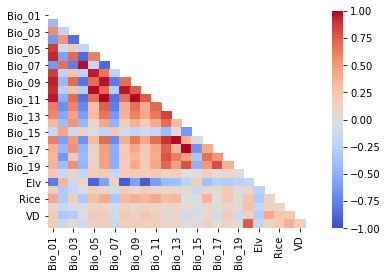

In [11]:
# see if there's evidence of multicolinearity

matrix = np.triu(X_train.corr())
sns.heatmap(X_train.corr(),mask = matrix, vmin = -1, vmax = 1, center = 0, cmap = 'coolwarm')

Some degree of correlation exists between many variables:

- Bio_1 with Bio_5,6,7,8,9,10,11,Elv
- Bio_7 with 4, etc

Next we fit a PCA. First step is to standardize the X variables, as variable scale impacts the evaluation of the variability. 

First PCA Component (w1):
 [ 0.26957579 -0.19113092  0.19767327 -0.23193047  0.18586745  0.28381002
 -0.24084433  0.20161432  0.27274261  0.21450259  0.28042354  0.26115194
  0.22644171  0.17418847 -0.09366043  0.23933891  0.18346163  0.17904295
  0.17910274  0.07242157 -0.19265789  0.0522221   0.12964846  0.04676012
  0.0542568   0.06671828]
Second PCA Component (w2):
 [ 0.18375021  0.11872922 -0.17958988  0.16435092  0.35242629  0.04133863
  0.17617221  0.31898568  0.08015421  0.31856625  0.07264117 -0.18527828
 -0.05710553 -0.28449931  0.19841082 -0.07706523 -0.28065893 -0.15072003
 -0.26122616  0.13034875 -0.29093064  0.09789821  0.12727351  0.09527241
  0.18414661  0.13048812]
Variance explained by each component:
 [4.36545866e-01 1.45232546e-01 8.43463687e-02 8.30041044e-02
 5.99577830e-02 4.48109154e-02 2.98330207e-02 2.75957092e-02
 2.30971740e-02 1.87139042e-02 1.46714352e-02 9.27883922e-03
 9.09352758e-03 5.58873590e-03 4.52936930e-03 1.62012954e-03
 7.34569480e-04 5.69444872

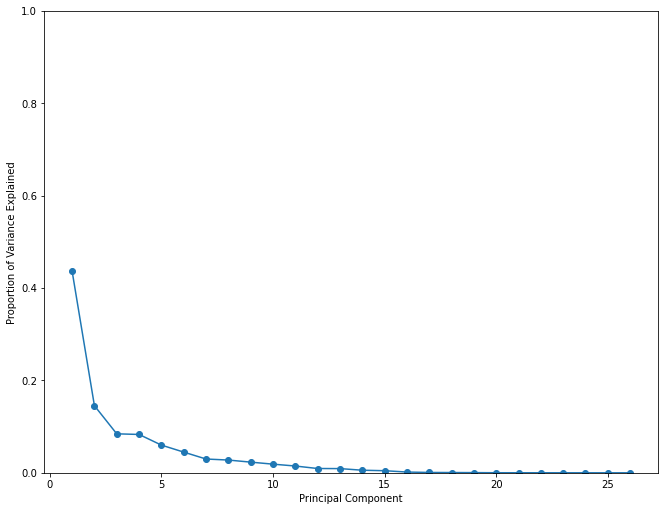

Proportion of variance explained by each PC:
[4.36545866e-01 1.45232546e-01 8.43463687e-02 8.30041044e-02
 5.99577830e-02 4.48109154e-02 2.98330207e-02 2.75957092e-02
 2.30971740e-02 1.87139042e-02 1.46714352e-02 9.27883922e-03
 9.09352758e-03 5.58873590e-03 4.52936930e-03 1.62012954e-03
 7.34569480e-04 5.69444872e-04 4.00620995e-04 1.37813773e-04
 1.01560182e-04 7.46284505e-05 4.57817093e-05 1.41140572e-05
 2.03785587e-06 1.63592492e-16]


In [13]:
# create/fit the standardized version of X
scaler = sk.preprocessing.StandardScaler()
scaler.fit(X_train)
Z = scaler.transform(X_train)

# create/fit the 'full' pca transformation on Z
pca = PCA().fit(Z)

# pcaZ: the pca-transformed X variables.
pcaZ = pca.transform(Z)

# convert to a data frame
pcaZ_df = pd.DataFrame(pcaZ, columns=[['PCA1' , 'PCA2', 'PCA3', 'PCA4','PCA5', 'PCA6', 'PCA7',\
                                      'PCA8' , 'PCA9', 'PCA10', 'PCA11','PCA12', 'PCA13', 'PCA14',\
                                      'PCA15' , 'PCA16', 'PCA17', 'PCA18','PCA19', 'PCA20', 'PCA21',\
                                      'PCA22' , 'PCA23', 'PCA24', 'PCA25','PCA26']])

# print the PC
print("First PCA Component (w1):\n",pca.components_[0,:])
print("Second PCA Component (w2):\n",pca.components_[1,:])

# here is the variance explained:
print("Variance explained by each component:\n",pca.explained_variance_ratio_)

# plot variance explained by variables
plt.figure(figsize=(11,8.5))
plt.plot(range(1,27),pca.explained_variance_ratio_,"-o")
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance Explained")
plt.ylim(0,1)
plt.show()

# Top 2 PCA explained the most variance
print("Proportion of variance explained by each PC:")
print(pca.explained_variance_ratio_)



The first 3 PCs explained much about the total variation in the X variables. Even more usefully, we can plot how much of the total variation we'd capture by using N PCs, see below: 


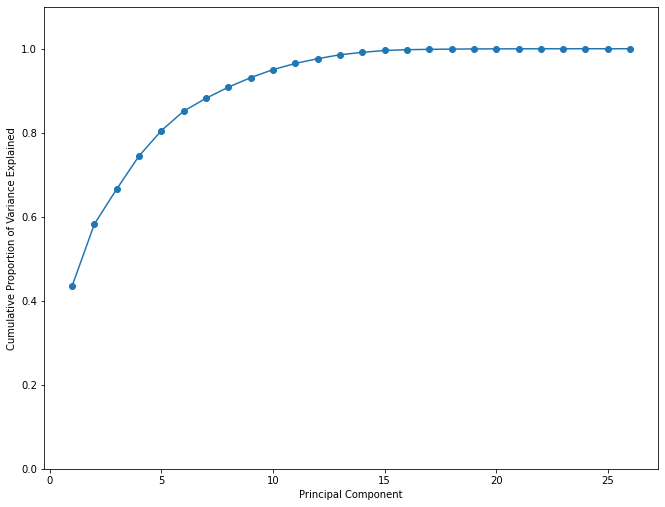

Total variance capturted when using N PCA components:
[0.43502542 0.5827559  0.66612749 0.74485962 0.80507298 0.85166512
 0.88197806 0.90855656 0.93114545 0.9502992  0.96495772 0.97632538
 0.9856677  0.99142497 0.99586905 0.99775241 0.99856548 0.99914095
 0.99955783 0.99974016 0.99986091 0.99993793 0.99998418 0.99999804
 1.         1.        ]


In [20]:

plt.figure(figsize=(11,8.5))
plt.plot(range(1,27),np.cumsum(pca.explained_variance_ratio_),"-o")
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Proportion of Variance Explained")
plt.ylim(0,1.1)
plt.show()

print("Total variance capturted when using N PCA components:")
print(np.cumsum(pca.explained_variance_ratio_))

The top 5 PCs explained 80% of the total variance.

In [14]:
#confirms that this is standardized (all PCA component should add to 1)
np.sum(pca.components_[0,:]**2) 

0.9999999999999994

## Principal Component Regression

In [28]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

The following slide explains some basic concept of the PCR. 

Source: Dr. Rachel Nethery, Harvard University. 

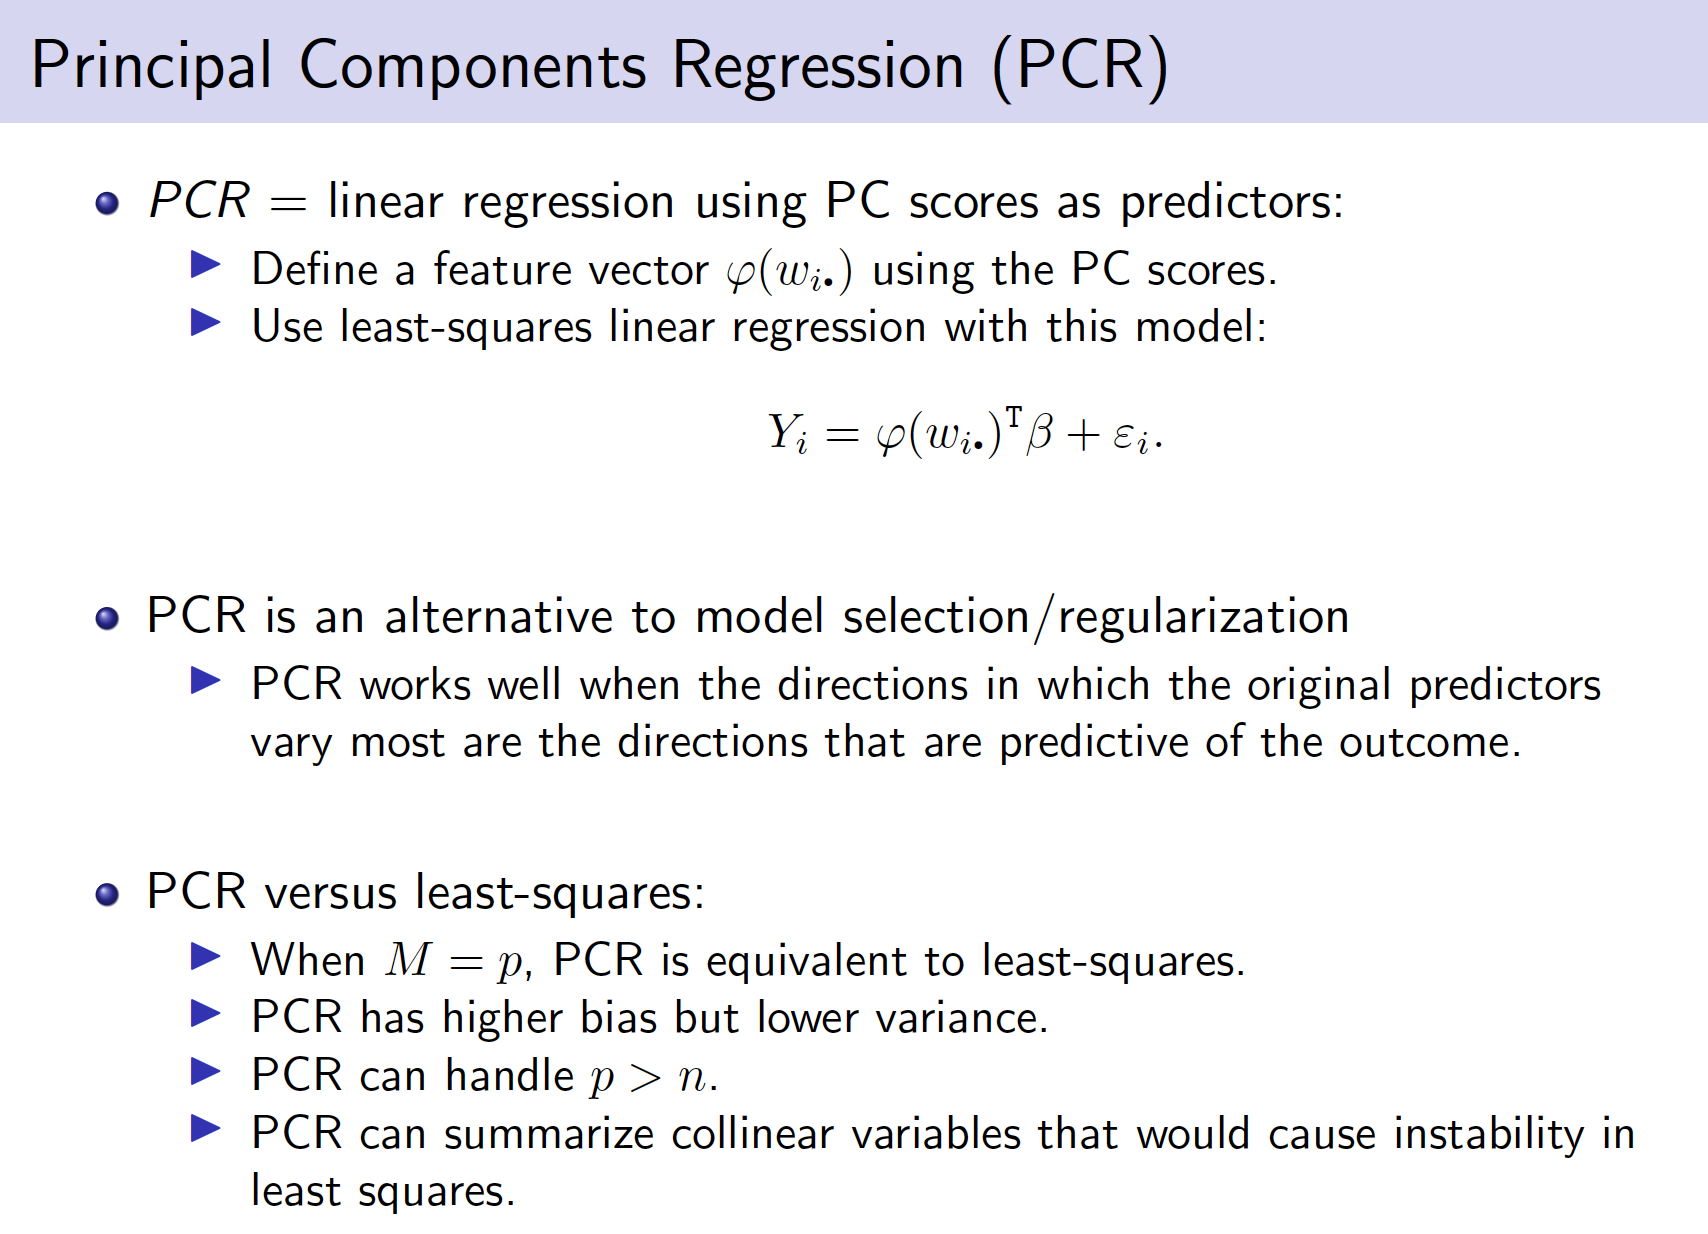

We first check how many principal components we should include in our model. There are 2 methods. 

- The first metod is outlined above, in which we calculate the amount of variability that each PC could explain, and select the top n PCs that cover the most of the variability. 

- The second method is explained below. We build a model, and calculate the training MSE using cross validation for all the PCs, by adding one PC at a time. We can treat this as a kind of elbow plot, in which the optimal k should be at a point where there is diminishing 'marginal return'. 

### Exploration: how many PCs to include

In [17]:
# 10-fold CV, with shuffle
n = len(pcaZ)
kf_10 = KFold(n_splits=10, shuffle=True, random_state=2)

regr_pcr = LinearRegression()
mse = []

# Do one CV to get MSE for just the intercept (no principal components in regression)
score = -1*cross_val_score(regr_pcr, np.ones((n,1)), Y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score) 

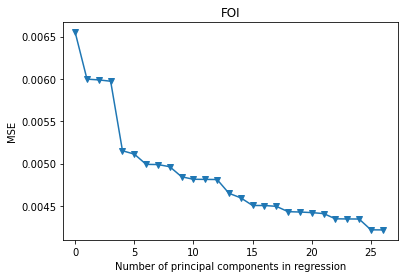

In [18]:
# Calculate MSE using CV for the 26 principle components, adding one component at the time.
for i in np.arange(1, 27):
    score = -1*cross_val_score(regr_pcr, pcaZ[:,:i], Y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot results    
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('FOI')
plt.xlim(xmin=-1);

The above shows that perhaps using 10 PCs will do for the model.

In [19]:
# pcaZ_test: the pca-transformed X_test variables.
pcaZ_test = pca.transform(scaler.transform(X_test))[:,:10]

In [17]:
# Get the loading scores for PC1 to see which factors had the largest influence on the outcome
loading_scores = pd.Series(pca.components_[0],index = X_train.columns)
sorted_loading_scores = loading_scores.abs().sort_values(ascending = False)
top10_variables = sorted_loading_scores[0:10].index.values
print(loading_scores[top10_variables])

Bio_06    0.283810
Bio_11    0.280424
Bio_09    0.272743
Bio_01    0.269576
Bio_12    0.261152
Bio_07   -0.240844
Bio_16    0.239339
Bio_04   -0.231930
Bio_13    0.226442
Bio_10    0.214503
dtype: float64


Loading scores are pretty similar for the top 10 variables, suggesting that lots of factors are playing similar roles. 

In [39]:
# Let's see what they are comprised of:
loading_matrix = pd.DataFrame.from_dict({'Variable': X_train.columns,
                        'PCA1': pca.components_[0],
                        'PCA2': pca.components_[1],
                        'PCA3': pca.components_[2],
                        'PCA4': pca.components_[3],
                        'PCA5': pca.components_[4],
                        }) 
loading_matrix

,Variable,PCA1,PCA2,PCA3,PCA4,PCA5
0,Bio_01,0.271324,0.175333,-0.124590,-0.043421,0.003111
1,Bio_02,-0.180445,0.147462,-0.273114,-0.197972,0.134907
2,Bio_03,0.209791,-0.166631,-0.166357,-0.298952,0.176260
3,Bio_04,-0.236908,0.147304,-0.064812,0.296606,-0.069604
4,Bio_05,0.191431,0.335794,-0.238985,0.082067,-0.011976
5,Bio_06,0.284713,0.040696,-0.027641,-0.126342,0.020797
6,Bio_07,-0.243328,0.166574,-0.120262,0.217011,-0.034720
7,Bio_08,0.205437,0.298659,-0.189791,0.143524,-0.055447
8,Bio_09,0.272561,0.081392,-0.090309,-0.159701,0.057322
9,Bio_10,0.217544,0.302425,-0.195964,0.102729,-0.031263


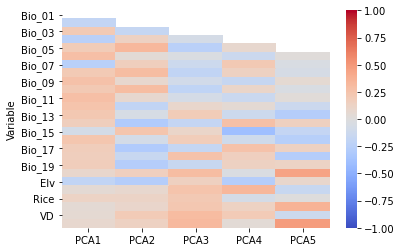

In [46]:
# We visualize the above matrix again
loading_matrix2 = loading_matrix.set_index('Variable')
matrix = np.triu(loading_matrix2)
sns.heatmap(loading_matrix2,mask = matrix, vmin = -1, vmax = 1, center = 0, cmap = 'coolwarm')

This loading plot tells us how much each PC is influenced by each of the original variables. As shown, none of the PCs is heavily influenced by any particular variable. This is related to the multicolinearity issue we highlighted, and also a sign that no particular variable is dominating over another. 

### Model building

In [43]:
#Add constant to X_train and x_test (add intercept)
pcaX_train_cst = sm.add_constant(pcaZ[:,:10])
pcaX_test_cst = sm.add_constant(pcaZ_test)

#Training
model = sm.OLS(Y_train, pcaX_train_cst).fit()

#Predict
Y_pred_train = model.predict(pcaX_train_cst)
Y_pred_test = model.predict(pcaX_test_cst)

#Perfromance Evaluation
train_score = mean_squared_error(Y_train, Y_pred_train)
test_score = mean_squared_error(Y_test, Y_pred_test)

print("Training Set Accuracy:",train_score)
print("Testing Set Accuracy:",test_score)


Training Set Accuracy: 0.005152716533088479
Testing Set Accuracy: 0.0049591714173833935


### Prediction performance

In [57]:
# get CI
pred2 = model.get_prediction(pcaX_test_cst)
y_lower_upper = pred2.conf_int() #default = 0.05

In [58]:
# dataframe
dat = np.concatenate((Y_test.reshape(-1,1), 
                      Y_pred_test.reshape(-1,1), 
                      y_lower_upper), axis = 1)
dat = pd.DataFrame(dat, columns = ['y','yhat','lower','upper'])
dat.head()

,y,yhat,lower,upper
0,0.178658,0.154979,0.153075,0.156884
1,0.027325,0.045839,0.044244,0.047433
2,0.144490,0.081563,0.079915,0.083212
3,0.147679,0.096297,0.093847,0.098746
4,0.036041,0.059219,0.057927,0.060512


In [59]:
# sort the dataframe for plotting
dat2 = dat.sort_values('y')
dat2.head()

,y,yhat,lower,upper
4590,4.273379e-08,0.187824,0.186099,0.189549
7438,4.289899e-08,0.193757,0.191903,0.195611
9288,4.300276e-08,0.192743,0.190948,0.194537
8344,4.301107e-08,0.194309,0.192446,0.196173
1437,4.338328e-08,0.196702,0.194998,0.198405


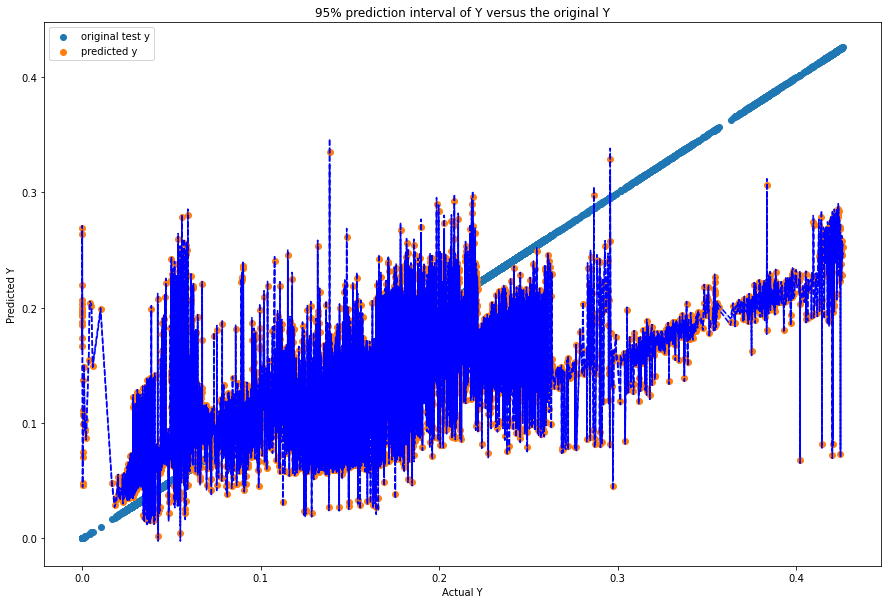

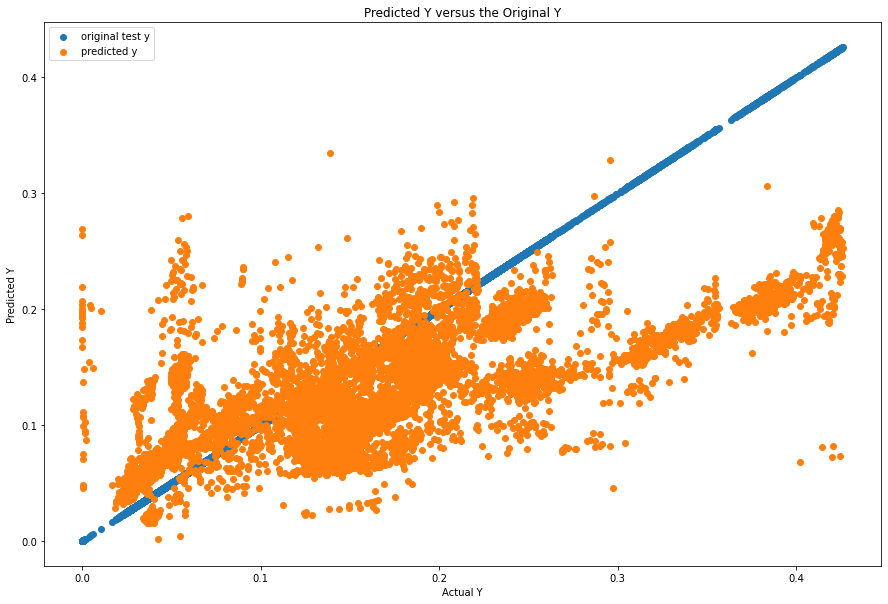

In [60]:
# plot1
fig, ax = plt.subplots(figsize = (15,10))
plt.scatter(dat2['y'], dat2['y'],label = 'original test y')
plt.scatter(dat2['y'], dat2['yhat'],label = 'predicted y')
ax.plot(dat2['y'], dat2['upper'], '--', color = 'b')
ax.plot(dat2['y'], dat2['lower'], '--', color = 'b')
ax.fill_between(dat2['y'], dat2['lower'],dat2['upper'], color = 'blue',alpha = .1)
plt.xlabel('Actual Y')
plt.ylabel('Predicted Y')
plt.title('95% prediction interval of Y versus the original Y')
plt.legend()

# plot2
fig, ax = plt.subplots(figsize = (15,10))
plt.scatter(dat2['y'], dat2['y'],label = 'original test y')
plt.scatter(dat2['y'], dat2['yhat'],label = 'predicted y')
# ax.plot(dat2['y'], dat2['upper'], '--', color = 'b')
# ax.plot(dat2['y'], dat2['lower'], '--', color = 'b')
# ax.fill_between(dat2['y'], dat2['lower'],dat2['upper'], color = 'blue',alpha = .1)
plt.xlabel('Actual Y')
plt.ylabel('Predicted Y')
plt.title('Predicted Y versus the Original Y')
plt.legend()

We see that when actual Y is less than 0.25, the prediction interval reasonably fluctuates around the actual value. However, when Y increases, the prediction tends to underestimate the actual Y value. 

We will see this pattern repeatedly in prediction using other methods. This is due to the fact that this part of the data (i.e. for those Y> 0.25) is underrepresented in the test set. See below. 

In [63]:
print(f'The proportion of Y_test > 0.25 out of the whole test sample is: ',sum(Y_test > .25)/len(Y_test))


The proportion of Y_test > 0.25 out of the whole test sample is:  0.1181400917980443


### Summary

- PCR is easy to operate and gives reasonable test MSE (although not very good compared to other ML methods)
- It is a good first step for identifying variable correlations and reducing dimensions. Also gives decent (and quick) result if we are more interested in prediction. 
- Another advantage is that the prediction interval calculation is relatively straight forward, and equivalent to those for the regular linear regression. We can do this because the PCs are independent with each other in the vector space. 
- The drawback is that it is difficult to directly interpret associations from PCR in terms of original variables. In regular OLS, we can find the p-values of the predictors as well as the CI of their coefficients. This does not apply to PCR. 